## Running a the "Simple SIRS" using Sparsemod movement model and Pei geography
*author: Frank Burkhart*

*as of git hash: 8493612*

After the implementation of the 'run' subcommand, we decided to stop 'sim' to run the hard coded models found in the 'examples' directory. This notebook, along with a few others, are being used to show what those hard coded examples looked.

Here we demonstrate the 'pei_spec' hard coded example. The construction of this model uses a the Pei SIRS intrapopulation model (IPM). Our populations of interest for this model are the six South Eastern U.S. states studied in the Pei model. For movement between these states, we use a daily commuter model with the possibility of random movement between subpopulations. 

In [1]:
import time
from datetime import date

import matplotlib.pyplot as plt
import numpy as np

import epymorph.movement as M
import epymorph.simulation as S
from epymorph.data import geo_library, ipm_library
from epymorph.util import stridesum

def pei_ruminate(plot_results: bool) -> None:
    movement_file =  './epymorph/data/mm/pei.movement'

    # Load movement model from spec file
    with open(movement_file, 'r') as file:
        spec_string = file.read()
        mvm_builder = M.load_movement_spec(spec_string)

    # Set up the simulation...
    geo = geo_library['pei']()
    sim = S.Simulation(
        geo=geo,
        ipm_builder=ipm_library['pei'](),
        mvm_builder=mvm_builder
    )

    # ... and run it.
    t0 = time.perf_counter()
    out = sim.run(
        param={
            'theta': 0.1,
            'move_control': 0.9,
            'infection_duration': np.double(4),
            'immunity_duration': np.double(90),
            'infection_seed_loc': 0,
            'infection_seed_size': 10_000
        },
        start_date=date(2023, 1, 1),
        duration_days=150,
        # If you want consistent results, you can provide a seeded RNG.
        rng=np.random.default_rng(1)
    )

    t1 = time.perf_counter()
    print(f"Simulation time: {(t1 - t0):.3f}s")

    # Output
    if plot_results:
        # Plot infections for all populations:
        event = 0
        fig, ax = plt.subplots()
        ax.set_title('Infection incidence')
        ax.set_xlabel('days')
        # ax.set_ylabel('infections (per 100k population)')
        ax.set_ylabel('infections')
        x_axis = list(range(out.ctx.clock.num_days))
        for pop_idx in range(geo.nodes):
            values = stridesum(
                out.incidence[:, pop_idx, event], out.ctx.clock.num_steps)
            # Scaled by population:
            # y_axis = values * 100_000 / geo.data['population'][pop_idx]
            # Unscaled:
            y_axis = values
            ax.plot(x_axis, y_axis, label=geo.labels[pop_idx])
        ax.legend()
        fig.tight_layout()
        plt.show()

        # Plot prevalence for the first population:
        pop = 0
        fig, ax = plt.subplots()
        ax.set_title('Prevalence in FL')
        ax.set_xlabel('days')
        ax.set_ylabel('persons (log scale)')
        ax.set_yscale('log')
        x_axis = [t.tausum for t in out.ctx.clock.ticks]
        events = ['S', 'I', 'R']
        for i, event in enumerate(events):
            y_axis = out.prevalence[:, pop, i]
            ax.plot(x_axis, y_axis, label=event)
        ax.legend()
        fig.tight_layout()
        plt.show()

Simulation time: 0.888s


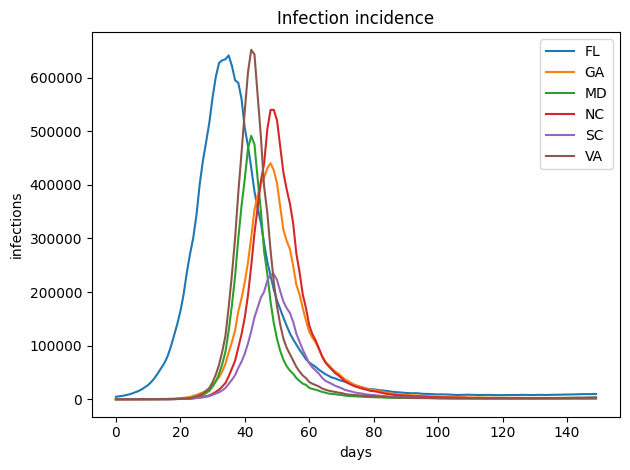

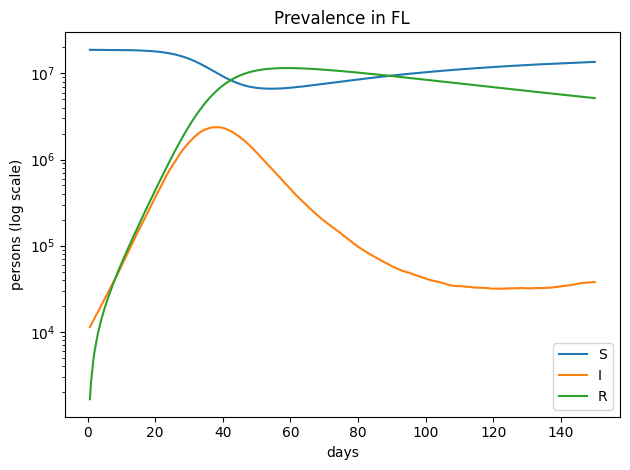

In [2]:
# Run the pei model and graph the output
pei_ruminate(plot_results= True)